In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import pickle

## Coverage evaluation

In [40]:
def coverage(intervals, target, coverage_mode='joint'):
    """ Determines whether intervals coverage the target prediction.

    Depending on the coverage_mode (either 'joint' or 'independent), will return
    either a list of whether each target or all targets satisfy the coverage.
    """

    lower, upper = intervals[0], intervals[1]

    horizon_coverages = np.logical_and(target >= lower, target <= upper)
    if coverage_mode == 'independent':
        return horizon_coverages
    else:  # joint coverage
        return np.all(horizon_coverages, axis=0)

In [43]:
coverages = []
intervals = []

for i, (x, y) in enumerate(zip(X_test, Y_test)): 
    y_pred, y_l_approx, y_u_approx = RNN_model_.predict(x)
    interval = np.array([y_l_approx[0], y_u_approx[0]])
    covers = coverage(interval, y.flatten().detach().numpy())
    coverages.append(covers)
    intervals.append(interval)
    if i % 50 == 0:
        print('Example {}'.format(i))

print('% of series within predicted intervals: {}'.format(np.mean(coverages)))

Example 0
Example 50
Example 100
Example 150
Example 200
Example 250
Example 300
Example 350
Example 400
Example 450
% of series within predicted intervals: 1.0


Text(0, 0.5, 'Prediction')

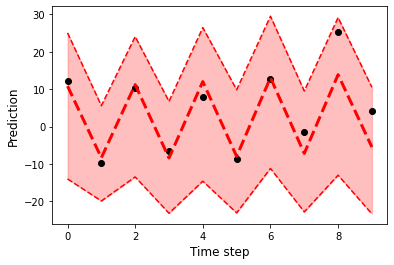

In [80]:
plt.fill_between(range(len(y)), y_l_approx[0], y_u_approx[0], color="r", alpha=0.25)
plt.plot(y_l_approx[0], linestyle="--", color="r")
plt.plot(y_u_approx[0], linestyle="--", color="r")
plt.plot(y_pred[0], linestyle="--", linewidth=3, color="r")

plt.scatter(range(len(y)), y, color="black")

plt.xlabel("Time step", fontsize=12)
plt.ylabel("Prediction", fontsize=12)

In [67]:
    
def plot_ts(X, Y, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(X))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target = X[i].tolist(), Y[i].tolist()
        
        horizon = len(target)
        length = len(sequence)
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = sequence[-1] + intervals[i][0][:horizon].flatten().tolist()
        upper = sequence[-1] + intervals[i][1][:horizon].flatten().tolist()
#         pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]

        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
#         ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

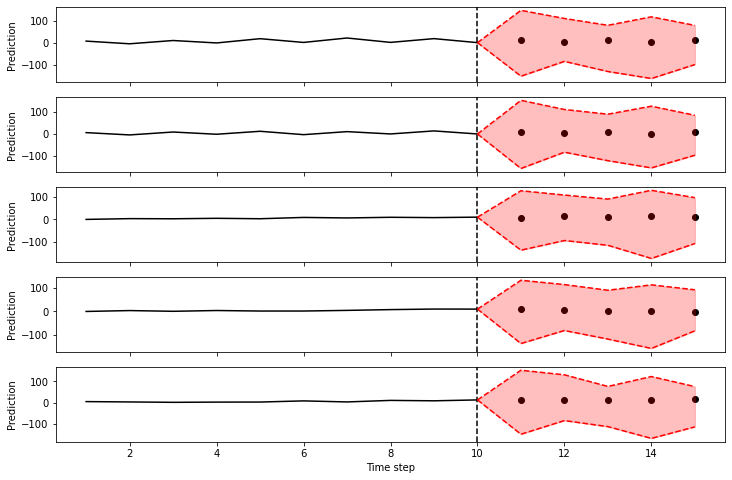

In [68]:
plot_ts(X_test, Y_test, coverages, intervals)

In [78]:
with open('results_bjrnn_1000_epochs.pkl', 'wb') as output:
    pickle.dump(resuts_bjrnn, output, pickle.HIGHEST_PROTOCOL)

## Static noise profile, no periodic component

In [15]:
def get_coverage(intervals, target, coverage_mode='joint'):
    """ Determines whether intervals coverage the target prediction.

    Depending on the coverage_mode (either 'joint' or 'independent), will return
    either a list of whether each target or all targets satisfy the coverage.
    """

    lower, upper = intervals[0], intervals[1]

    horizon_coverages = np.logical_and(target >= lower, target <= upper)
    if coverage_mode == 'independent':
        return horizon_coverages
    else:  # joint coverage
        return np.all(horizon_coverages, axis=0)

In [8]:
import gc

In [32]:
from models.rnn import RNN     # library containing the base RNN model implementation in torch
from models.uncertainty import RNN_uncertainty_wrapper
from models.losses import single_losses
from utils.make_data import *       # library for generating synthetic data 

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

params = dict({"INPUT_SIZE":1,      # RNN parameters
               "EPOCH":epochs, 
               "N_STEPS":epochs//batch_size, 
               "BATCH_SIZE":batch_size, 
               "MAX_STEPS":seq_len,
               "OUTPUT_SIZE":horizon,
               "mode":"LSTM"})

# results_static_noise_no_periodic = []
for i in range(4, 6):
    noise_profile = [0.1 * i for k in range(seq_len + horizon)]
    X_train, Y_train = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths,
                                                                   return_raw=True)

    X_test, Y_test = generate_autoregressive_forecast_dataset(n_samples=min(n_test_samples, 500), # because code is slow 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths,
                                                                   return_raw=True)
    
    RNN_model = RNN(**params)
    RNN_model.fit(X_train, Y_train)
    
    RNN_model_ = RNN_uncertainty_wrapper(RNN_model)
    
    coverages = []
    intervals = []

    for j, (x, y) in enumerate(zip(X_test, Y_test)): 
        y_pred, y_l_approx, y_u_approx = RNN_model_.predict(x)
        interval = np.array([y_l_approx[0], y_u_approx[0]])
        covers = get_coverage(interval, y.flatten().detach().numpy())
        coverages.append(covers)
        intervals.append(interval)
        if j % 50 == 0:
            print('Example {}'.format(j))
            
    mean_coverage = np.mean(coverages)
    np_intervals = np.array(intervals)
    interval_widths = (np_intervals[:, 1] - np_intervals[:, 0]).mean(axis=0)

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_static_noise_no_periodic.append(result)
    del RNN_model
    del RNN_model_
    gc.collect()

with open('results_bjrnn_1000_epochs_results_static_noise_no_periodic.pkl', 'wb') as output:
    pickle.dump(results_static_noise_no_periodic, output, pickle.HIGHEST_PROTOCOL)

Epoch:  0 | train loss: 63.0638
Epoch:  50 | train loss: 10.0039
Epoch:  100 | train loss: 8.2270
Epoch:  150 | train loss: 6.2254
Epoch:  200 | train loss: 5.4448
Epoch:  250 | train loss: 5.7949
Epoch:  300 | train loss: 4.7508
Epoch:  350 | train loss: 3.9480
Epoch:  400 | train loss: 3.9652
Epoch:  450 | train loss: 3.0326
Epoch:  500 | train loss: 4.2378
Epoch:  550 | train loss: 4.5754
Epoch:  600 | train loss: 3.7151
Epoch:  650 | train loss: 3.2437
Epoch:  700 | train loss: 3.9066
Epoch:  750 | train loss: 3.5982
Epoch:  800 | train loss: 4.5271
Epoch:  850 | train loss: 3.8436
Epoch:  900 | train loss: 2.6945
Epoch:  950 | train loss: 2.8282
Example 0
Example 50
Example 100
Example 150
Example 200
Example 250
Example 300
Example 350
Example 400
Example 450
Model 4:	coverage: 1.0	widths: [29.70712175 32.2419688  36.25516169 35.82950735 35.10840432]
Epoch:  0 | train loss: 50.0922
Epoch:  50 | train loss: 9.0148
Epoch:  100 | train loss: 9.1638
Epoch:  150 | train loss: 8.0127
E

In [18]:
for i, (x, y) in enumerate(zip(X_test, Y_test)): 
    y_pred, y_l_approx, y_u_approx = RNN_model_.predict(x)
    interval = np.array([y_l_approx[0], y_u_approx[0]])
    covers = get_coverage(interval, y.flatten().detach().numpy())
    coverages.append(covers)
    intervals.append(interval)
    if i % 50 == 0:
        print('Example {}'.format(i))
        
mean_coverage = np.mean(coverages)
np_intervals = np.array(intervals)
interval_widths = (np_intervals[:, 1] - np_intervals[:, 0]).mean(axis=0)

result = {'coverages': coverages,
           'intervals': intervals,
           'mean_coverage': mean_coverage,
           'interval_widths': interval_widths}

print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
results_static_noise_no_periodic.append(result)
del RNN_model
del RNN_model_
gc.collect()

Example 0
Example 50
Example 100
Example 150
Example 200
Example 250
Example 300
Example 350
Example 400
Example 450
Model 499:	coverage: 1.0	widths: [104.19228963 106.85713277  73.6337753  139.76958941  67.78157175]


57

## Time-dependent, no periodic component

In [31]:
# from utils.train_synthetic import train_conformal_forecaster
time_dependent_results = train_conformal_forecaster(noise_mode='time-dependent')

**Joint coverage**

In [32]:
for result in time_dependent_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

92.0\%
91.6\%
92.0\%
92.2\%
91.2\%


**Independent coverage**

In [33]:
for result in time_dependent_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9600, 0.9840, 0.9820, 0.9940, 0.9820])
[96.0\%, 99.4\%]

tensor([0.9840, 0.9880, 0.9840, 0.9560, 0.9840])
[95.6\%, 98.8\%]

tensor([0.9820, 0.9820, 0.9720, 0.9760, 0.9780])
[97.2\%, 98.2\%]

tensor([0.9800, 0.9800, 0.9740, 0.9920, 0.9840])
[97.4\%, 99.2\%]

tensor([0.9780, 0.9800, 0.9900, 0.9780, 0.9800])
[97.8\%, 99.0\%]



**Mean absolute error**

In [34]:
for result in time_dependent_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([2.3385, 3.1437, 3.7521, 4.0304, 4.2055], grad_fn=<MeanBackward1>)
3.49 \(\pm\) 2.69

tensor([2.8506, 3.5456, 4.1636, 4.6017, 4.7974], grad_fn=<MeanBackward1>)
3.99 \(\pm\) 3.13

tensor([3.9038, 4.5945, 5.0242, 5.6742, 5.4950], grad_fn=<MeanBackward1>)
4.94 \(\pm\) 3.79

tensor([4.3761, 5.1412, 6.1135, 5.9675, 6.7823], grad_fn=<MeanBackward1>)
5.68 \(\pm\) 4.35

tensor([5.4778, 6.2312, 7.0181, 7.4857, 7.7957], grad_fn=<MeanBackward1>)
6.80 \(\pm\) 5.33



**Interval widths**

In [35]:
for result in time_dependent_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([12.8132, 17.8813, 21.2491, 23.2933, 23.6637], requires_grad=True)
tensor(19.7801, grad_fn=<MeanBackward0>) tensor(4.5201, grad_fn=<StdBackward0>)

tensor([17.1109, 20.6710, 22.1549, 23.8422, 27.9436], requires_grad=True)
tensor(22.3445, grad_fn=<MeanBackward0>) tensor(3.9944, grad_fn=<StdBackward0>)

tensor([22.0895, 25.7180, 28.0620, 32.3142, 33.7863], requires_grad=True)
tensor(28.3940, grad_fn=<MeanBackward0>) tensor(4.7818, grad_fn=<StdBackward0>)

tensor([25.1534, 29.1088, 32.5214, 39.1727, 41.6589], requires_grad=True)
tensor(33.5230, grad_fn=<MeanBackward0>) tensor(6.8675, grad_fn=<StdBackward0>)

tensor([31.4864, 34.9797, 43.5343, 42.1337, 47.7705], requires_grad=True)
tensor(39.9809, grad_fn=<MeanBackward0>) tensor(6.6164, grad_fn=<StdBackward0>)



## Static noise, no periodic component

In [15]:
static_results = train_conformal_forecaster(noise_mode='static')

**Joint coverage**

In [16]:
for result in static_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

95.0\%
94.4\%
93.2\%
93.4\%
92.4\%


**Independent coverage**

In [17]:
for result in static_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9780, 0.9860, 0.9860, 0.9780, 0.9800])
[97.8\%, 98.6\%]

tensor([0.9840, 0.9780, 0.9820, 0.9840, 0.9840])
[97.8\%, 98.4\%]

tensor([0.9720, 0.9800, 0.9780, 0.9760, 0.9800])
[97.2\%, 98.0\%]

tensor([0.9820, 0.9840, 0.9720, 0.9640, 0.9680])
[96.4\%, 98.4\%]

tensor([0.9780, 0.9680, 0.9780, 0.9720, 0.9760])
[96.8\%, 97.8\%]



**Mean absolute error**

In [18]:
for result in static_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([1.8995, 2.5804, 3.1298, 3.5363, 3.7695], grad_fn=<MeanBackward1>)
2.98 \(\pm\) 2.41

tensor([1.9419, 2.7828, 3.3485, 3.6435, 3.9276], grad_fn=<MeanBackward1>)
3.13 \(\pm\) 2.48

tensor([1.9291, 2.7528, 3.5822, 4.0033, 4.2119], grad_fn=<MeanBackward1>)
3.30 \(\pm\) 2.68

tensor([2.0626, 2.7283, 3.1654, 3.6567, 3.9644], grad_fn=<MeanBackward1>)
3.12 \(\pm\) 2.52

tensor([1.9955, 2.6569, 3.4058, 3.6974, 3.8686], grad_fn=<MeanBackward1>)
3.12 \(\pm\) 2.54



**Interval widths**

In [19]:
for result in static_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([11.4507, 15.3996, 19.2507, 21.0733, 22.1902], requires_grad=True)
tensor(17.8729, grad_fn=<MeanBackward0>) tensor(4.4199, grad_fn=<StdBackward0>)

tensor([12.1119, 16.7439, 18.5749, 21.4060, 23.3589], requires_grad=True)
tensor(18.4391, grad_fn=<MeanBackward0>) tensor(4.3570, grad_fn=<StdBackward0>)

tensor([11.4600, 16.2007, 19.3880, 23.0490, 23.6155], requires_grad=True)
tensor(18.7427, grad_fn=<MeanBackward0>) tensor(5.0548, grad_fn=<StdBackward0>)

tensor([11.7586, 16.4172, 18.6265, 20.4468, 23.1094], requires_grad=True)
tensor(18.0717, grad_fn=<MeanBackward0>) tensor(4.2988, grad_fn=<StdBackward0>)

tensor([11.1144, 15.1959, 18.9498, 20.8329, 22.0748], requires_grad=True)
tensor(17.6336, grad_fn=<MeanBackward0>) tensor(4.4759, grad_fn=<StdBackward0>)



## Periodic component, static noise

In [20]:
periodic_results = train_conformal_forecaster(noise_mode='periodic')

**Joint coverage**

In [21]:
for result in periodic_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

97.6\%
93.2\%


**Independent coverage**

In [22]:
for result in periodic_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9920, 0.9960, 0.9920, 0.9940, 0.9960, 0.9960, 0.9960, 0.9980, 0.9980,
        0.9960])
[99.2\%, 99.8\%]

tensor([0.9880, 0.9840, 0.9940, 0.9920, 0.9960, 0.9920, 0.9920, 0.9840, 0.9800,
        0.9880])
[98.0\%, 99.6\%]



**Mean absolute error**

In [23]:
for result in periodic_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([ 7.4363,  7.4771,  9.3391,  9.7334, 11.2197, 11.6655, 12.9182, 13.1885,
        13.9832, 13.9535], grad_fn=<MeanBackward1>)
11.09 \(\pm\) 8.85

tensor([ 8.8976, 11.8946, 13.1749, 12.8028, 12.3277, 12.7602, 14.0399, 15.6923,
        15.0483, 13.8442], grad_fn=<MeanBackward1>)
13.05 \(\pm\) 10.23



**Interval widths**

In [24]:
for result in periodic_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([ 52.4876,  59.0043,  65.9346,  75.7754,  80.5779,  82.2282,  89.9427,
         98.7705,  94.7996, 103.5400], requires_grad=True)
tensor(80.3061, grad_fn=<MeanBackward0>) tensor(17.1339, grad_fn=<StdBackward0>)

tensor([55.9986, 74.3429, 84.9096, 81.1981, 78.3629, 84.8813, 90.4266, 94.0434,
        90.9185, 91.8483], requires_grad=True)
tensor(82.6930, grad_fn=<MeanBackward0>) tensor(11.3192, grad_fn=<StdBackward0>)



## Plotting

In [38]:
import pickle

In [81]:
def plot_timeseries(noise_mode, baseline, index=None, forecast_only=False):
    
    datasets = []
    for i in ([2, 10] if noise_mode == 'periodic' else range(1, 6)):
        with open('processed_data/synthetic_{}_raw_{}.pkl'.format(noise_mode, i), 'rb') as f:
            datasets.append(pickle.load(f))
        
    with open('saved_results/{}_{}.pkl'.format(noise_mode, baseline), 'rb') as f:
        all_results = pickle.load(f)
        
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(30, 4), sharey=True)

    for j, ax in enumerate(axs.flat):
        _, _, dataset = datasets[j]
        results = all_results[j]
        
        X, Y = dataset
            
        if index is None:
            index = range(len(X))
        i = np.random.choice(index)

        
        # Derive unpadded sequences and targets
        sequence, target = X[i], Y[i]
        
        horizon = len(target)
        length = len(sequence)
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        upper_limit = results['Upper limit']
        lower_limit = results['Lower limit']
        
        lower = [sequence[-1].item()] + lower_limit[i].flatten().tolist()
        upper = [sequence[-1].item()] + upper_limit[i].flatten().tolist()
        preds = [sequence[-1].item()] + results['Point predictions'][i].flatten().tolist()

        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), preds, linestyle="--", linewidth=3, color="r")

        if j == 0:
            ax.set(ylabel='Prediction')  
        ax.set(xlabel='Time step')
    
#     plt.xlabel('Time step')
#     plt.ylabel('Prediction')
    plt.show()

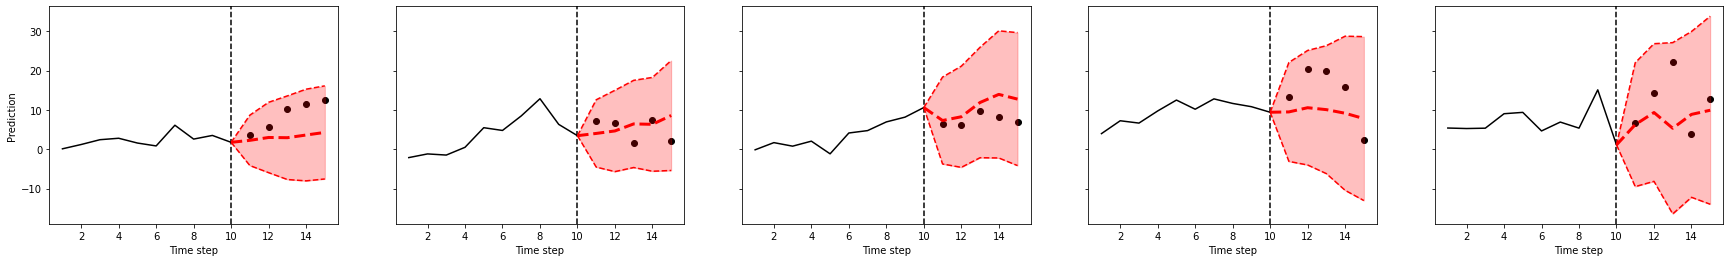

In [82]:
plot_timeseries(noise_mode='time-dependent', baseline='CPRNN')